In [1]:
import torch
from torch import nn
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import spacy
import copy
from tqdm import tqdm
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import font_manager
font = font_manager.FontProperties(fname="simhei.ttf")
plt.rcParams['axes.unicode_minus']=False

In [2]:
class NMTDataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return {
            'src': self.src[index]['sentence'],
            'src_len': self.src[index]['len'],
            'trg': self.trg[index]['sentence'],
            'trg_len': self.trg[index]['len']
        }

In [3]:
spacy_en = spacy.load('en')
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
with open('cmn.txt', 'r', encoding='utf-8') as f:
        data = f.read()

data = data.strip().split('\n')

print('number of examples: ', len(data))

en_data = [line.split('\t')[0] for line in data]
zh_data = [line.split('\t')[1] for line in data]

assert len(en_data) == len(zh_data)

number of examples:  23610


In [5]:
zh_words = set()
en_words = set()

for i in tqdm(range(len(zh_data))):
    en_seg = tokenize_en(en_data[i])
    zh_seg = list(zh_data[i])

    zh_words.update(zh_seg)
    en_words.update(en_seg)

100%|██████████| 23610/23610 [00:03<00:00, 7821.54it/s] 


In [6]:
zh_word2idx = {value: index + 4 for index, value in enumerate(zh_words)}

zh_word2idx['<pad>'] = 0
zh_word2idx['<sos>'] = 1
zh_word2idx['<eos>'] = 2
zh_word2idx['<unk>'] = 3

zh_idx2word = {zh_word2idx[k]: k for k in zh_word2idx.keys()}

In [7]:
en_word2idx = {value: index + 4 for index, value in enumerate(en_words)}

en_word2idx['<pad>'] = 0
en_word2idx['<sos>'] = 1
en_word2idx['<eos>'] = 2
en_word2idx['<unk>'] = 3

en_idx2word = {en_word2idx[k]: k for k in en_word2idx.keys()}

In [8]:
zh = []
en = []

for i in tqdm(range(len(zh_data))):
    en_seg = tokenize_en(en_data[i])
    zh_seg = list(zh_data[i])

    en_sentence = [en_word2idx['<sos>']] + [en_word2idx[w] for w in en_seg] + [en_word2idx['<eos>']]
    zh_sentence = [zh_word2idx['<sos>']] + [zh_word2idx[w] for w in zh_seg] + [zh_word2idx['<eos>']]

    en_len = len(en_sentence)
    zh_len = len(zh_sentence)

    zh.append({
         'sentence': zh_sentence,
         'len': zh_len
    })
    en.append({
        'sentence': en_sentence,
        'len': en_len
    })

100%|██████████| 23610/23610 [00:01<00:00, 14536.81it/s]


In [9]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(zh_word2idx)
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
HID_DIM = 512
EMB_DIM = 256
N_LAYERS = 2
EPOCH = 200

In [10]:
def padding_batch(batch):

    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]

    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])

    srcs = []
    trgs = []

    for d in batch:
        src = copy.deepcopy(d['src'])
        trg = copy.deepcopy(d['trg'])

        src.extend([en_word2idx["<pad>"]]*(src_max-d["src_len"]))
        trg.extend([zh_word2idx["<pad>"]]*(trg_max-d["trg_len"]))

        srcs.append(src)
        trgs.append(trg)

    srcs = torch.tensor(srcs, dtype=torch.long, device=DEVICE)
    trgs = torch.tensor(trgs, dtype=torch.long, device=DEVICE)

    batch = {"src":srcs.T, "src_lens":src_lens,
             "trg":trgs.T, "trg_lens":trg_lens}
    return batch

In [11]:
# encoder是bidirectional的
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, 
                 dropout=0.5):
        
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout,
                           bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)

        self.n_directions = 2
        
        self.fc1 = nn.Linear(hid_dim * 2, hid_dim)
        self.fc2 = nn.Linear(hid_dim * 2, hid_dim)
        
    def forward(self, x, lens, hidden, cell):
        
        seq_len = x.shape[0]
        batch_size = x.shape[1]
        
        # x [seq_len, batch_size]
        embedded = self.dropout(self.embedding(x))
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lens, enforce_sorted=False,
                                                   batch_first=False)
        
        outputs, (hidden, cell) = self.rnn(packed, (hidden, cell))
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs [seq_len, batch_size, n_directions * hid_dim]
         
        hidden = hidden.view(self.n_layers, self.n_directions, batch_size, self.hid_dim)        
        hidden = torch.tanh(self.fc1(torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim = 2)))
        # hidden [n_layers, batch_size, hid_dim]

        cell = cell.view(self.n_layers, self.n_directions, batch_size, self.hid_dim)
        cell = torch.tanh(self.fc2(torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim = 2)))
        # cell [n_layers, batch_size, hid_dim]
        
        return outputs, hidden, cell

In [12]:
# decoder是unidirectional的
class Decoder(nn.Module):
    
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers,
                 dropout=0.5):
        
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim + hid_dim * 2, hid_dim, n_layers, dropout=dropout,
                           bidirectional=False)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hid_dim * 3 + emb_dim, output_dim)
        
        self.attn = nn.Linear(hid_dim * 3, hid_dim)
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        
    def forward(self, x, hidden, cell, encoder_outputs, mask):
        
        batch_size = x.shape[0]

        # hidden [n_layers, batch_size, hid_dim]
        # encoder_outputs [seq_len, batch_size, 2 * hid_dim]     
        
        encoder_seq_len = encoder_outputs.shape[0]
        
        top_layer_hidden = hidden[-1, :, :].reshape(1, batch_size, -1)
        # top_layer_hidden [1, batch_size, hid_dim]
        
        top_layer_hidden = top_layer_hidden.repeat(encoder_seq_len, 1, 1)
        # top_layer_hidden [seq_len, batch_size, hid_dim]
        
        energy = torch.tanh(self.attn(torch.cat((top_layer_hidden, encoder_outputs), dim = 2))) 
        
        #energy [seq_len, batch_size, hid_dim]

        attention_weights = self.v(energy).squeeze(2)
    
        attention_weights = torch.masked_fill(attention_weights, mask == 0, -1e10)
        
        attention_weights = F.softmax(attention_weights, dim=0)
        
        attention_weights = attention_weights.reshape(-1, 1, encoder_seq_len)
        # attention_weights [batch_size, 1, seq_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs [batch_size, seq_len, hid_dim * 2]
        
        context = torch.bmm(attention_weights, encoder_outputs)
        # context [batch_size, 1, hid_dim * 2]
        
        context = context.permute(1, 0, 2)
        # context [1, batch_size, hid_dim * 2]
                
        x = x.reshape(1, -1)
        # x [1, batch_size]
        
        embedded = self.dropout(self.embedding(x))
        # embedded [1, batch_size, emb_dim]
        
        rnn_input = torch.cat((embedded, context), dim=2)
        # rnn_input [1, batch_size, hid_dim * 2 + emb_dim]
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # output [1, batch_size, hid_dim]
        
        # hidden [n_layers, batch_size, hid_dim]
        
        output = output.squeeze(0)
        embedded = embedded.squeeze(0)
        context = context.squeeze(0)
        
        prediction = self.fc(torch.cat((output, embedded, context), dim=1))
        # prediction [batch_size, output_dim]
        
        prediction = F.log_softmax(prediction, dim=1)
        
        return prediction, hidden, cell, attention_weights

In [13]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, device, max_trg_len=100):
        
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        self.encoder.to(device)
        self.decoder.to(device)
        
        self.max_trg_len = max_trg_len
        
        self.n_encoder_directions = 2
    
    def create_mask(self, src):
        mask = src != 0
        # mask [seq_len, batch_size]
        return mask
        
    def forward(self, src, src_lens, trg, trg_lens, teacher_forcing_ratio=0.5):
        
        # src [seq_len, batch_size]
        # trg [seq_len, batch_size]
        
        batch_size = src.shape[1]
        
        hidden = torch.zeros(self.encoder.n_layers * self.n_encoder_directions, batch_size,
                             self.encoder.hid_dim, device=self.device)
        
        cell = torch.zeros(self.encoder.n_layers * self.n_encoder_directions, batch_size,
                           self.encoder.hid_dim, device=self.device)
        
        encoder_outputs, hidden, cell = self.encoder(src, src_lens, hidden, cell)
        
        x = trg[0, :]
        
        max_trg_len = max(trg_lens)
        
        decoder_outputs = torch.zeros(max_trg_len, batch_size, self.decoder.output_dim)
        
        mask = self.create_mask(src)

        for t in range(1, max_trg_len):
            decoder_output, hidden, cell, _ = self.decoder(x.to(self.device),
                                                           hidden, cell, encoder_outputs, mask)
            
            decoder_outputs[t] = decoder_output
            
            top1 = decoder_output.argmax(dim=1).detach()
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            
            x = trg[t, :] if teacher_forcing else top1
            
        return decoder_outputs
    
    
    def translate(self, src, src_lens, trg):
        
        batch_size = src.shape[1]
        
        hidden = torch.zeros(self.encoder.n_layers * self.n_encoder_directions, batch_size,
                             self.encoder.hid_dim, device=self.device)
        
        cell = torch.zeros(self.encoder.n_layers * self.n_encoder_directions, batch_size,
                           self.encoder.hid_dim, device=self.device)
        
        encoder_outputs, hidden, cell = self.encoder(src, src_lens, hidden, cell)
        
        x = trg[0, :]
        
        decoder_outputs = torch.zeros(self.max_trg_len, batch_size, self.decoder.output_dim)
        
        mask = self.create_mask(src)
        
        attentions = torch.zeros(self.max_trg_len, 1, src_lens[0]).to(self.device)
        
        for t in range(0, self.max_trg_len):
            
            decoder_output, hidden, cell, attention_weights = self.decoder(x.to(self.device),
                                                           hidden, cell, encoder_outputs, mask)
            
            attentions[t] = attention_weights
            
            decoder_outputs[t] = decoder_output
            
            top1 = decoder_output.argmax(dim=1).detach()
            
            x = top1
        
        attentions = attentions.squeeze(1).cpu().detach()
        
        return decoder_outputs, attentions

In [14]:
encoder = Encoder(INPUT_DIM, emb_dim=EMB_DIM, hid_dim=HID_DIM, n_layers=N_LAYERS)
decoder = Decoder(OUTPUT_DIM, emb_dim=EMB_DIM, hid_dim=HID_DIM, n_layers=N_LAYERS)
model = Seq2Seq(encoder, decoder, DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index=0)

In [15]:
dataset = NMTDataset(en, zh)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=padding_batch, shuffle=True)

In [16]:
best_valid_loss = sys.maxsize
print_every = 10

In [ ]:
for epoch in range(EPOCH):
    
    print_loss_total = 0
    
    model.train()
    for index, batch in enumerate(dataloader):
        
        src = batch['src']
        src_lens = batch['src_lens']
        trg = batch['trg']
        trg_lens = batch['trg_lens']
        
        optimizer.zero_grad()
        
        outputs = model(src, src_lens, trg, trg_lens)
        
        outputs = outputs[1:, :, :]
        
        outputs = outputs.reshape(-1, OUTPUT_DIM)
        
        trg = trg[1:, :]
        
        trg = trg.reshape(-1).cpu()
        
        loss = criterion(outputs, trg)
        
        print_loss_total += loss.item()
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        
        if (index + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            info = 'Train Epoch [{}/{}], Avg Loss: {:.4f}'. \
                    format(epoch + 1, EPOCH, print_loss_avg)
            print(info)
    
    valid_loss = 0
    model.eval()
    
    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            
            src = batch['src']
            src_lens = batch['src_lens']
            trg = batch['trg']
            trg_lens = batch['trg_lens']
            
            output = model(src, src_lens, trg, trg_lens, teacher_forcing_ratio=0)
            
            outputs = model(src, src_lens, trg, trg_lens)
        
            outputs = outputs[1:, :, :]

            outputs = outputs.reshape(-1, OUTPUT_DIM)

            trg = trg[1:, :]

            trg = trg.reshape(-1).cpu()

            loss = criterion(outputs, trg)
            
            valid_loss += loss.item()
    
    valid_loss = valid_loss / len(dataloader)
    info = 'Train Epoch [{}/{}], Valid Loss: {:.4f}'. \
            format(epoch + 1, EPOCH, valid_loss)
    print(info)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention.pth')

In [18]:
print('best valid loss: {}'.format(best_valid_loss))

best valid loss: 0.9000755480817846


In [19]:
model.load_state_dict(torch.load('attention.pth'))

<All keys matched successfully>

In [20]:
def display_attention(sentence, translation, attentions):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attentions = attentions.numpy()
    
    cax = ax.matshow(attentions, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(sentence, 
                       rotation=45)
    ax.set_yticklabels([''] + translation, {'fontsize': '20'}, font_properties=font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [21]:
def translate_and_show_attention(model, en):
    en = tokenize_en(en)
    en.append('<eos>')
    
    en = ['<sos>'] + en
    
    en_show = [''] + en
    
    en_len = len(en)

    en_data = []

    for w in en:
        if w in en_word2idx.keys():
            en_data.append(en_word2idx[w])
        else:
            en_data.append(en_word2idx['<unk>'])
    en = en_data
    
    en = [en]

    en = torch.LongTensor(en).permute(1, 0)
    
    model.eval()
    with torch.no_grad():
        outputs, attentions = model.translate(en.to(DEVICE), [en_len], torch.LongTensor([[1]]))

        outputs = outputs.permute(1, 0, 2).cpu().detach().numpy()

        outputs = np.argmax(outputs, axis=2)

        outputs = outputs[0]

        zh_data = []

        for w in outputs:
            if w in zh_idx2word.keys():
                zh_data.append(zh_idx2word[w])
                if zh_idx2word[w] == '<eos>':
                    break
            else:
                zh_data.append('<unk>')

        print(zh_data)
    
    display_attention(en_show, zh_data, attentions[:len(zh_data)])

['我', '爱', '你', '。', '<eos>']


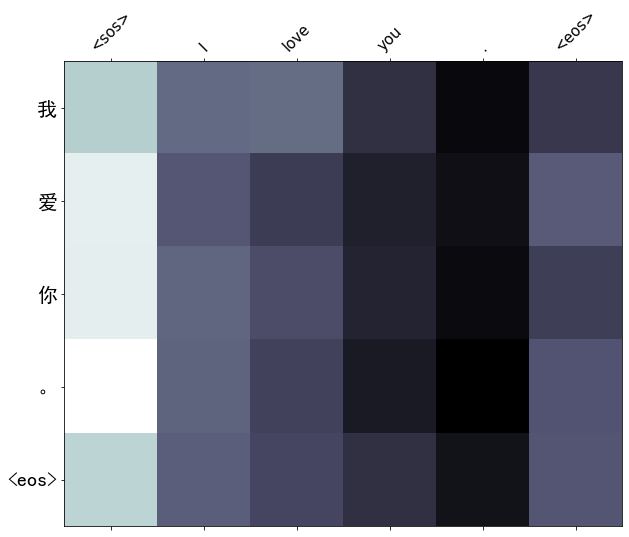

In [22]:
translate_and_show_attention(model, 'I love you.')

['她', '一', '週', '週', '內', '會', '回', '來', '。', '<eos>']


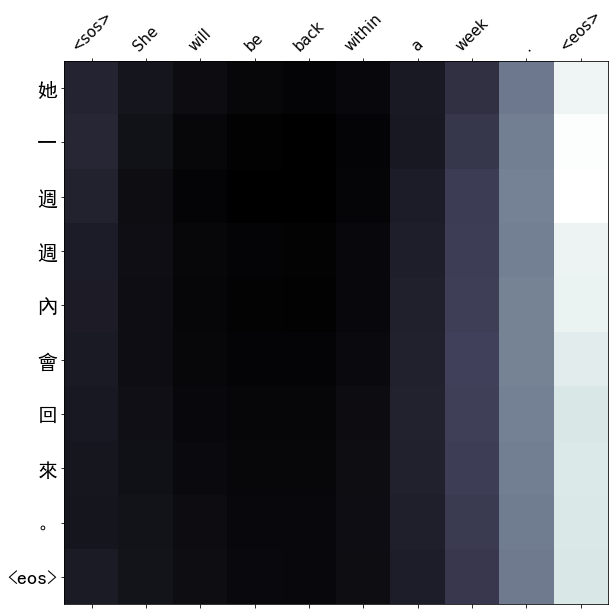

In [23]:
# 她一週之內會回來。
translate_and_show_attention(model, 'She will be back within a week.')

['他', '扔', '了', '一', '塊', '石', '頭', '到', '池', '塘', '裡', '。', '<eos>']


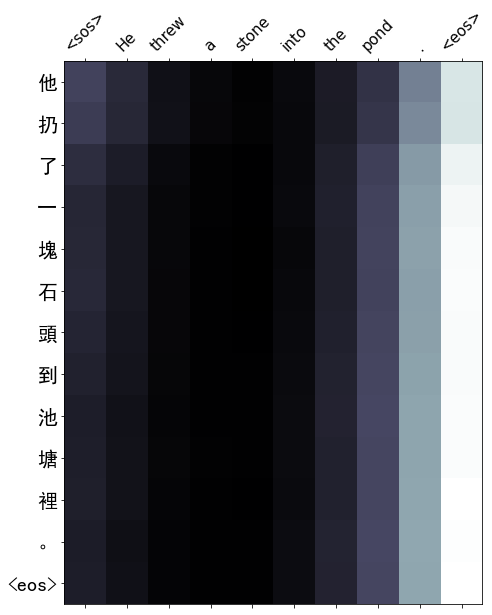

In [24]:
# 他扔一塊石頭到池塘裡。
translate_and_show_attention(model, 'He threw a stone into the pond.')

['我', '們', '問', '問', '問', '湯', '姆', '看', '他', '看', '怎', '麼', '。', '<eos>']


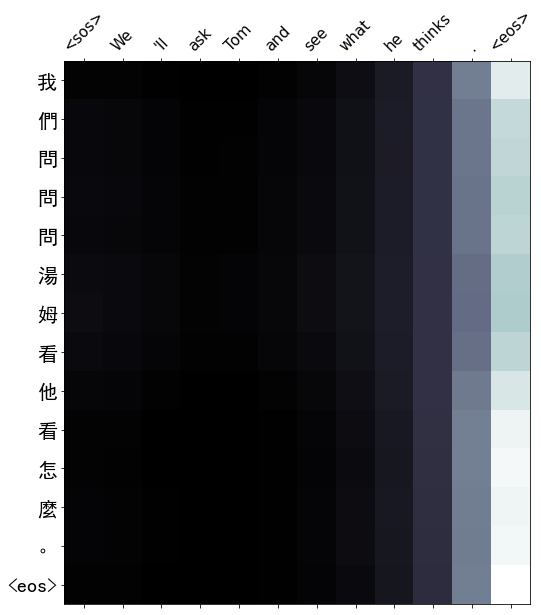

In [25]:
# 我們要問問湯姆，看看他怎麼想。
translate_and_show_attention(model, 'We\'ll ask Tom and see what he thinks.')

['他', '不', '不', '了', '咖', '啡', '的', '味', '苦', '。', '<eos>']


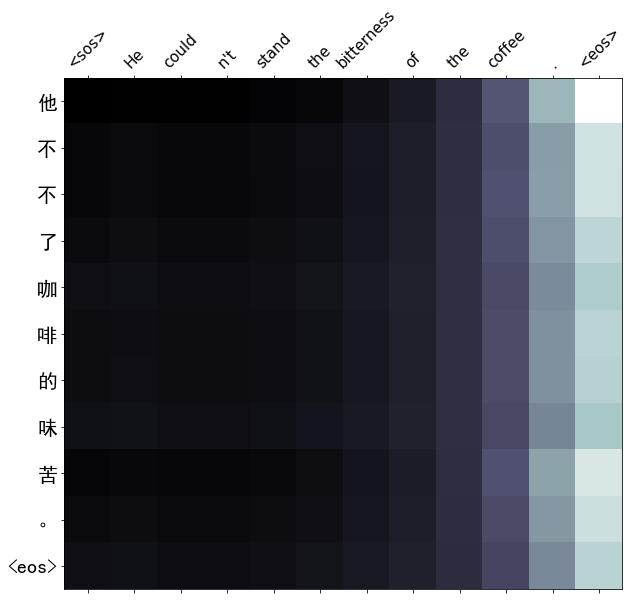

In [26]:
# 他受不了咖啡的苦味。
translate_and_show_attention(model, 'He couldn\'t stand the bitterness of the coffee.')

['我', '喜', '歡', '吃', '面', '包', '。', '<eos>']


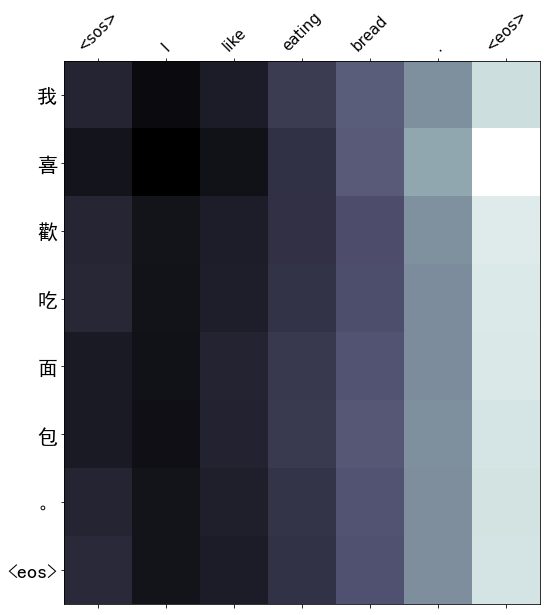

In [28]:
translate_and_show_attention(model, 'I like eating bread.')

['我', '從', '來', '沒', '有', '看', '過', '他', '穿', '牛', '仔', '褲', '。', '<eos>']


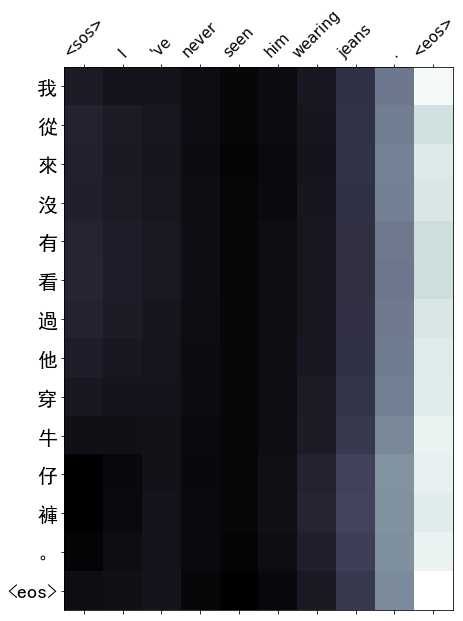

In [31]:
# 我從來沒有看過他穿牛仔褲。
translate_and_show_attention(model, 'I\'ve never seen him wearing jeans.')

['我', '們', '玩', '棋', '玩', '得', '很', '開', '心', '。', '<eos>']


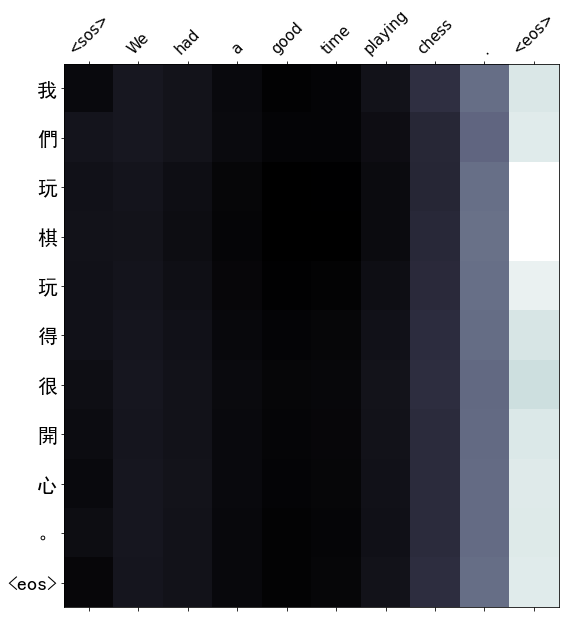

In [32]:
# 我們下棋玩得很開心。
translate_and_show_attention(model, 'We had a good time playing chess.')

['星', '期', '天', '的', '時', '候', '，', '不', '不', '用', '工', '作', '。', '<eos>']


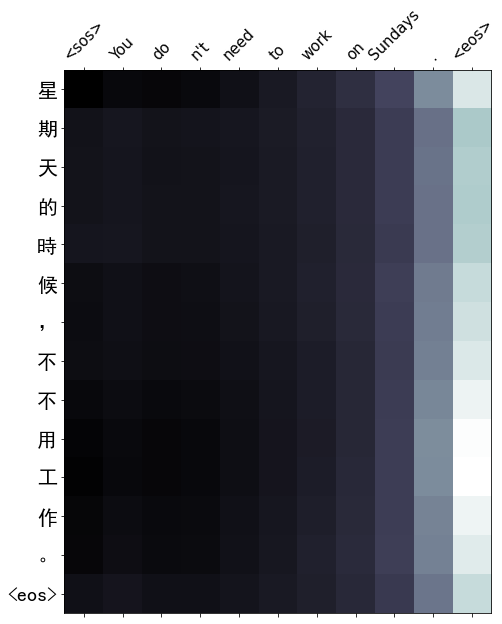

In [33]:
# 星期天的時候，你不用工作。
translate_and_show_attention(model, 'You don\'t need to work on Sundays.')

['她', '不', '喜', '歡', '足', '球', '。', '<eos>']


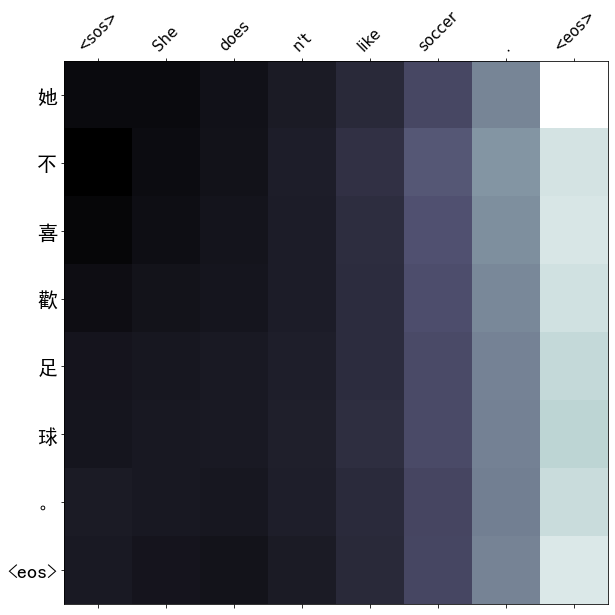

In [34]:
# 她不喜欢足球。
translate_and_show_attention(model, 'She doesn\'t like soccer.')

['他', '告', '诉', '我', '他', '那', '时', '忙', '忙', '。', '<eos>']


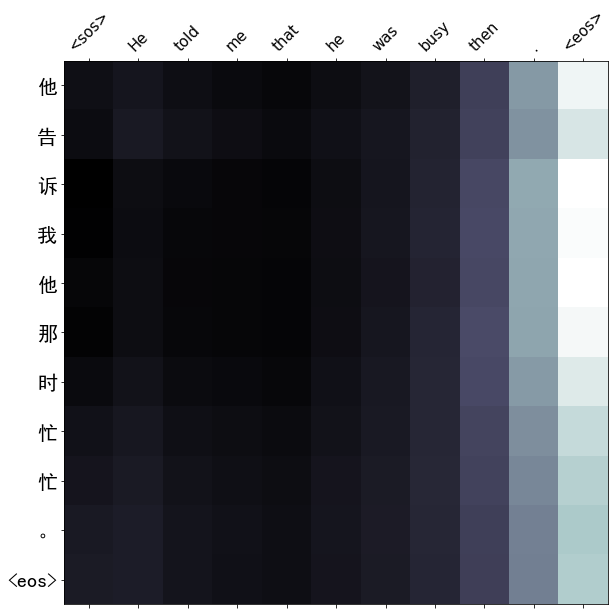

In [37]:
# 他告诉我他那时很忙。
translate_and_show_attention(model, 'He told me that he was busy then.')

['有', '人', '正', '在', '彈', '鋼', '琴', '。', '<eos>']


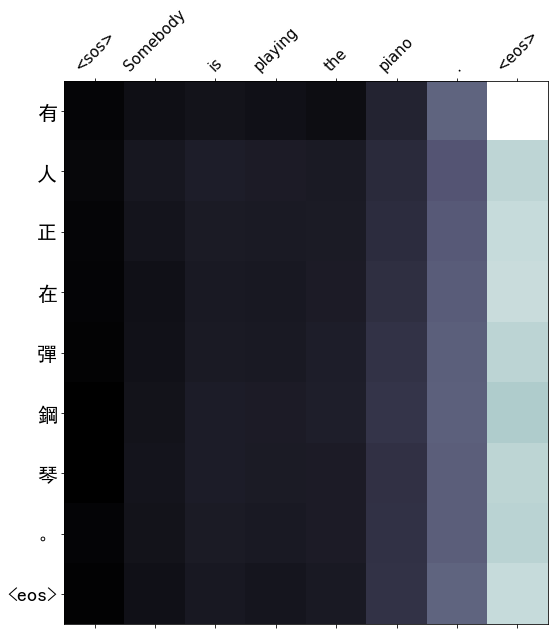

In [39]:
# 有人正在彈鋼琴。
translate_and_show_attention(model, 'Somebody is playing the piano.')

['他', '們', '有', '危', '險', '。', '<eos>']


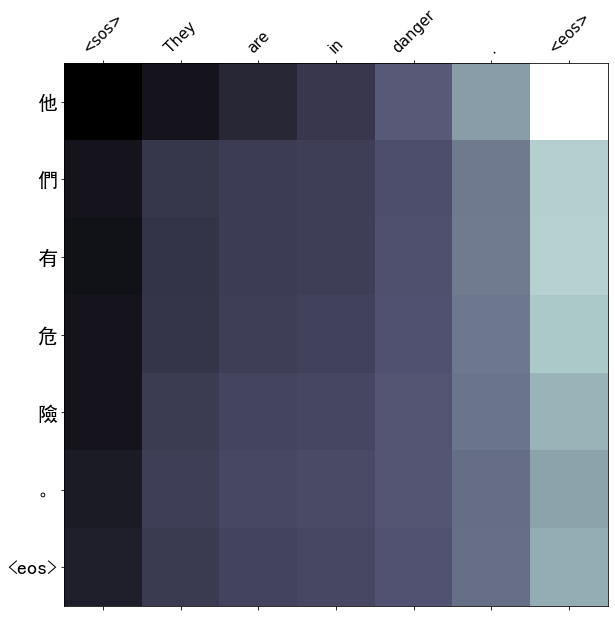

In [40]:
# 他們有危險。
translate_and_show_attention(model, 'They are in danger.')

['即', '使', '我', '知', '道', '答', '案', '，', '我', '也', '不', '会', '告', '诉', '你', '。', '<eos>']


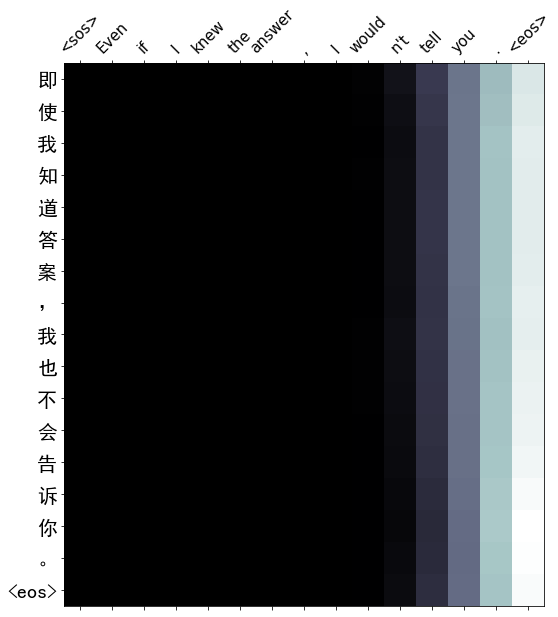

In [41]:
translate_and_show_attention(model, 'Even if I knew the answer, I wouldn\'t tell you.')